# Container Metrics Analysis - Day 2 Exploratory Analysis

**Project**: Predictive Autoscaling  
**Date**: October 14, 2025  
**Objective**: Analyze collected metrics for patterns and prepare for ML model training

## Overview
This notebook performs exploratory analysis on container metrics collected from:
- webapp (Flask application)
- db (PostgreSQL)
- cache (Redis)

### Metrics Collected:
1. **CPU Usage** - Container CPU utilization
2. **Memory Usage** - Container memory consumption
3. **Network Traffic** - RX/TX bytes per second
4. **HTTP Requests** - Application request rates

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import glob
import os

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✅ Libraries imported successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis date: 2025-10-15 14:47:22


## 1. Data Loading

Load the most recent metrics export from the `data/raw/` directory.

In [2]:
# Find the most recent metrics file
data_dir = '../data/raw'
metrics_files = glob.glob(os.path.join(data_dir, 'metrics_*.csv'))

if not metrics_files:
    print("❌ No metrics files found!")
else:
    # Get the most recent file
    latest_file = max(metrics_files, key=os.path.getctime)
    print(f"📁 Loading: {os.path.basename(latest_file)}")
    
    # Load data
    df = pd.read_csv(latest_file)

    print(df.columns)
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"\n✅ Loaded {len(df):,} records")
    print(f"   Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"   Duration: {df['timestamp'].max() - df['timestamp'].min()}")
    print(f"\n📊 Dataset shape: {df.shape}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Rows: {df.shape[0]:,}")

📁 Loading: metrics_20251015_144438.csv
Index(['label_endpoint', 'label_instance', 'label_job', 'label_le',
       'label_method', 'label_status', 'metric_name', 'timestamp', 'value'],
      dtype='object')

✅ Loaded 5,929 records
   Time range: 2025-10-15 14:14:38 to 2025-10-15 14:44:38
   Duration: 0 days 00:30:00

📊 Dataset shape: (5929, 9)
   Columns: 9
   Rows: 5,929


## 2. Data Exploration

In [3]:
# Display basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

print("\n📋 Column Names:")
print(df.columns.tolist())

print("\n📊 Data Types:")
print(df.dtypes)

print("\n📈 Basic Statistics:")
print(df.describe())

print("\n🔍 First Few Rows:")
display(df.head(10))

DATASET OVERVIEW

📋 Column Names:
['label_endpoint', 'label_instance', 'label_job', 'label_le', 'label_method', 'label_status', 'metric_name', 'timestamp', 'value']

📊 Data Types:
label_endpoint            object
label_instance            object
label_job                 object
label_le                 float64
label_method              object
label_status             float64
metric_name               object
timestamp         datetime64[ns]
value                    float64
dtype: object

📈 Basic Statistics:
       label_le  label_status                      timestamp     value
count 5445.0000      484.0000                           5929 5929.0000
mean        inf      275.0000  2025-10-15 14:29:38.000000256    2.3133
min      0.0050      200.0000            2025-10-15 14:14:38    0.0000
25%      0.0500      200.0000            2025-10-15 14:22:08    0.6175
50%      0.5000      200.0000            2025-10-15 14:29:38    2.4117
75%      5.0000      275.0000            2025-10-15 14:37:08  

/mnt/f/DPN/AWS/MLOPs/predictive-autoscaling/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,label_endpoint,label_instance,label_job,label_le,label_method,label_status,metric_name,timestamp,value
0,/error,webapp:5000,webapp,NaN,GET,500.0000,http_requests,2025-10-15 14:14:38,0.2382
1,/medium,webapp:5000,webapp,0.7500,NaN,NaN,http_request_duration,2025-10-15 14:14:38,2.6203
2,/heavy,webapp:5000,webapp,0.0100,NaN,NaN,http_request_duration,2025-10-15 14:14:38,0.0000
3,/heavy,webapp:5000,webapp,7.5000,NaN,NaN,http_request_duration,2025-10-15 14:14:38,1.3101
4,/light,webapp:5000,webapp,2.5000,NaN,NaN,http_request_duration,2025-10-15 14:14:38,4.7046
5,/heavy,webapp:5000,webapp,0.0250,NaN,NaN,http_request_duration,2025-10-15 14:14:38,0.0000
6,/heavy,webapp:5000,webapp,5.0000,NaN,NaN,http_request_duration,2025-10-15 14:14:38,1.3101
7,/light,webapp:5000,webapp,5.0000,NaN,NaN,http_request_duration,2025-10-15 14:14:38,4.7046
8,/light,webapp:5000,webapp,10.0000,NaN,NaN,http_request_duration,2025-10-15 14:14:38,4.7046
9,/medium,webapp:5000,webapp,0.2500,NaN,NaN,http_request_duration,2025-10-15 14:14:38,2.6203


In [4]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES")
print("=" * 80)

missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✅ No missing values!")

MISSING VALUES
      Column  Missing Count  Percentage
label_method           5445     91.8367
label_status           5445     91.8367
    label_le            484      8.1633


In [5]:
# Analyze metrics distribution
print("=" * 80)
print("METRICS DISTRIBUTION")
print("=" * 80)

print("\n📊 Records per Metric:")
metric_counts = df['metric_name'].value_counts()
for metric, count in metric_counts.items():
    percentage = 100 * count / len(df)
    print(f"   {metric:30s}: {count:6,} ({percentage:5.1f}%)")

print("\n🏷️  Unique Labels:")
label_cols = [col for col in df.columns if col.startswith('label_')]
for col in label_cols:
    unique_vals = df[col].nunique()
    print(f"   {col:30s}: {unique_vals} unique values")
    if unique_vals < 20:
        print(f"      Values: {df[col].unique().tolist()}")

METRICS DISTRIBUTION

📊 Records per Metric:
   http_request_duration         :  5,445 ( 91.8%)
   http_requests                 :    484 (  8.2%)

🏷️  Unique Labels:
   label_endpoint                : 4 unique values
      Values: ['/error', '/medium', '/heavy', '/light']
   label_instance                : 1 unique values
      Values: ['webapp:5000']
   label_job                     : 1 unique values
      Values: ['webapp']
   label_le                      : 15 unique values
      Values: [nan, 0.75, 0.01, 7.5, 2.5, 0.025, 5.0, 10.0, 0.25, 0.1, 0.075, 0.05, inf, 0.5, 0.005, 1.0]
   label_method                  : 1 unique values
      Values: ['GET', nan]
   label_status                  : 2 unique values
      Values: [500.0, nan, 200.0]


## 3. Time Series Visualization

Visualize the collected metrics over time to identify patterns and anomalies.

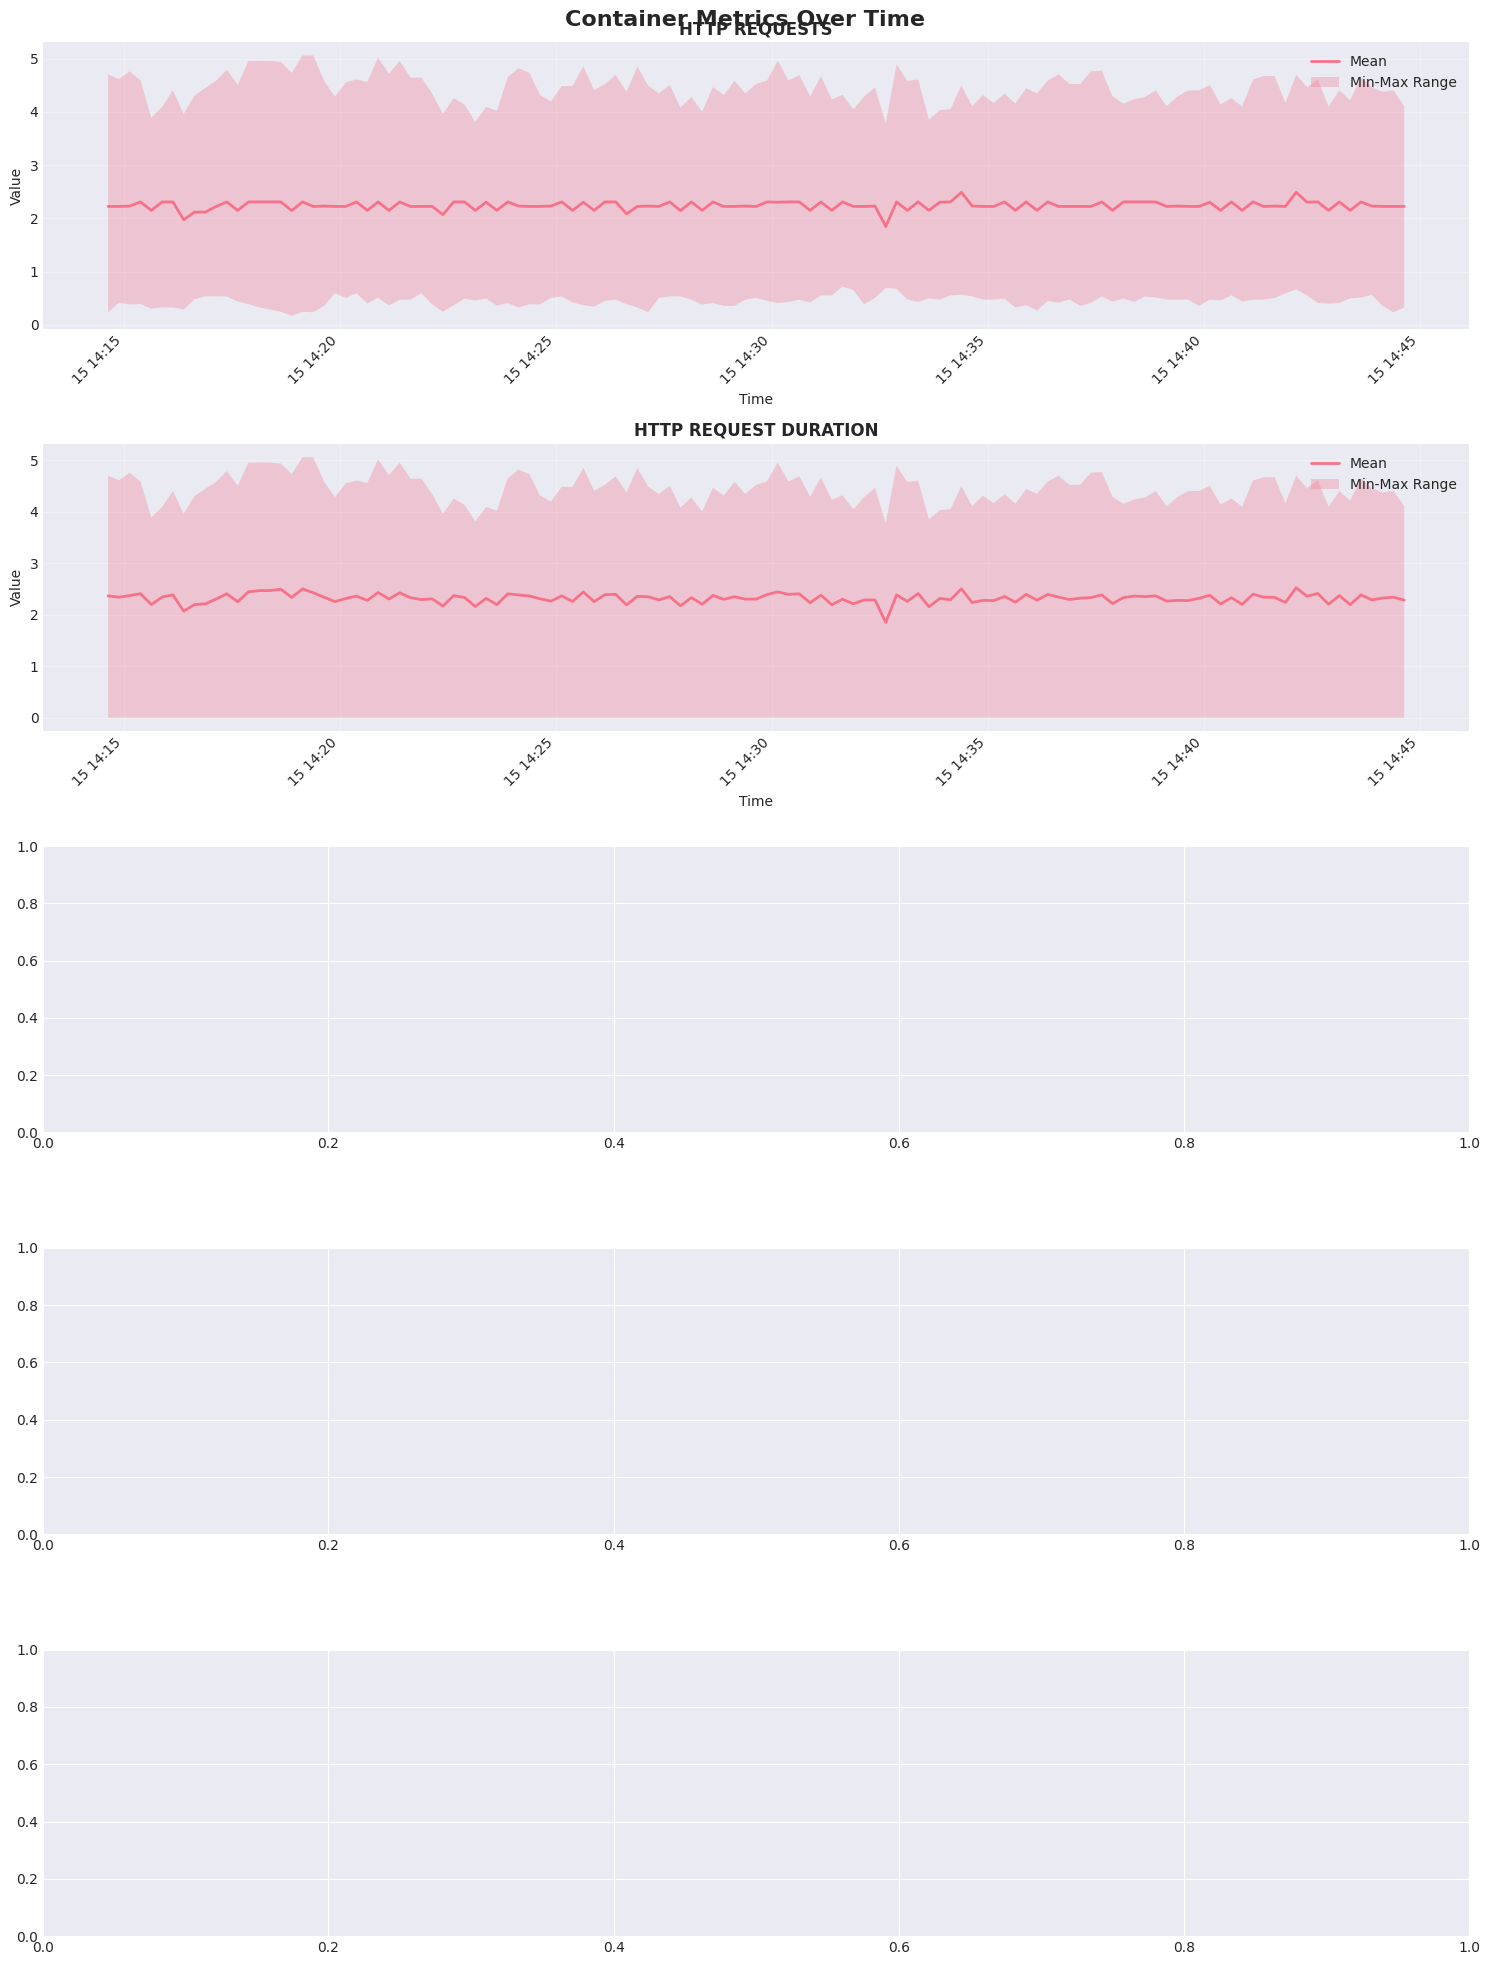

✅ Time series plots generated


In [6]:
# Create time series plots for each metric
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
fig.suptitle('Container Metrics Over Time', fontsize=16, fontweight='bold')

metrics = df['metric_name'].unique()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    metric_data = df[df['metric_name'] == metric]
    
    # Group by timestamp and aggregate (in case of multiple series)
    time_series = metric_data.groupby('timestamp')['value'].agg(['mean', 'min', 'max'])
    
    # Plot mean with confidence interval
    ax.plot(time_series.index, time_series['mean'], label='Mean', linewidth=2)
    ax.fill_between(time_series.index, time_series['min'], time_series['max'], 
                     alpha=0.3, label='Min-Max Range')
    
    ax.set_title(f'{metric.upper().replace("_", " ")}', fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✅ Time series plots generated")

## 4. Container-Specific Analysis

Break down metrics by individual containers to understand their behavior.

In [7]:
# Analyze CPU usage by container
print("=" * 80)
print("CPU USAGE BY CONTAINER")
print("=" * 80)

cpu_data = df[df['metric_name'] == 'container_cpu']

if 'label_name' in cpu_data.columns:
    # Filter for our containers
    containers = ['metrics-webapp', 'metrics-db', 'metrics-cache']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle('CPU Usage by Container', fontsize=16, fontweight='bold')
    
    for idx, container in enumerate(containers):
        container_data = cpu_data[cpu_data['label_name'] == container]
        
        if len(container_data) > 0:
            ax = axes[idx]
            
            # Aggregate by timestamp
            ts = container_data.groupby('timestamp')['value'].mean()
            
            ax.plot(ts.index, ts.values, linewidth=2)
            ax.set_title(f'{container}', fontweight='bold')
            ax.set_xlabel('Time')
            ax.set_ylabel('CPU Usage (cores)')
            ax.grid(True, alpha=0.3)
            
            # Add statistics
            mean_cpu = ts.mean()
            max_cpu = ts.max()
            ax.axhline(mean_cpu, color='red', linestyle='--', label=f'Mean: {mean_cpu:.4f}')
            ax.legend()
            
            print(f"\n{container}:")
            print(f"   Mean CPU: {mean_cpu:.4f} cores")
            print(f"   Max CPU:  {max_cpu:.4f} cores")
            print(f"   Std Dev:  {ts.std():.4f}")
            
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No container name labels found in CPU data")

CPU USAGE BY CONTAINER
⚠️  No container name labels found in CPU data


In [8]:
# Analyze memory usage by container
print("=" * 80)
print("MEMORY USAGE BY CONTAINER")
print("=" * 80)

mem_data = df[df['metric_name'] == 'container_memory']

if 'label_name' in mem_data.columns and len(mem_data) > 0:
    containers = ['metrics-webapp', 'metrics-db', 'metrics-cache']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle('Memory Usage by Container', fontsize=16, fontweight='bold')
    
    for idx, container in enumerate(containers):
        container_data = mem_data[mem_data['label_name'] == container]
        
        if len(container_data) > 0:
            ax = axes[idx]
            
            # Aggregate and convert to MB
            ts = container_data.groupby('timestamp')['value'].mean() / (1024 ** 2)
            
            ax.plot(ts.index, ts.values, linewidth=2, color='green')
            ax.set_title(f'{container}', fontweight='bold')
            ax.set_xlabel('Time')
            ax.set_ylabel('Memory Usage (MB)')
            ax.grid(True, alpha=0.3)
            
            # Add statistics
            mean_mem = ts.mean()
            max_mem = ts.max()
            ax.axhline(mean_mem, color='red', linestyle='--', label=f'Mean: {mean_mem:.1f} MB')
            ax.legend()
            
            print(f"\n{container}:")
            print(f"   Mean Memory: {mean_mem:.1f} MB")
            print(f"   Max Memory:  {max_mem:.1f} MB")
            print(f"   Std Dev:     {ts.std():.1f} MB")
            
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No container memory data found")

MEMORY USAGE BY CONTAINER
⚠️  No container memory data found


## 5. HTTP Request Analysis

Analyze HTTP request patterns to understand application load.

HTTP REQUEST PATTERNS


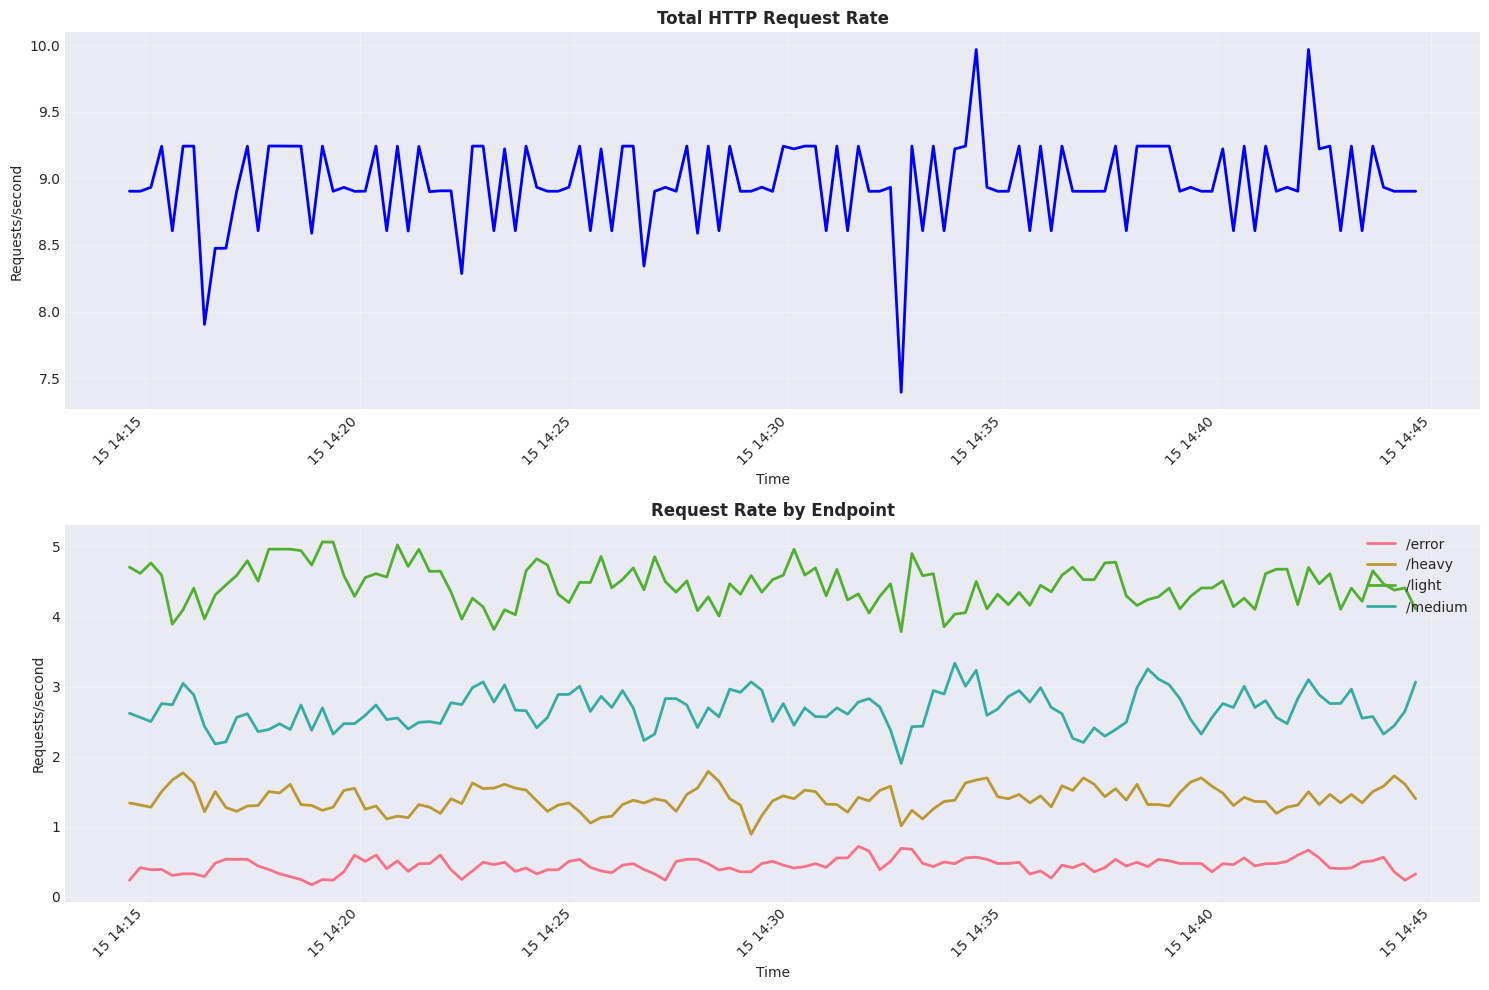


Total HTTP Requests: 1,085
Mean Request Rate: 2.24 req/s
Peak Request Rate: 5.06 req/s

📊 Requests by Endpoint:
   /light              :      538 ( 49.6%)
   /medium             :      323 ( 29.8%)
   /heavy              :      169 ( 15.6%)
   /error              :       54 (  4.9%)


In [9]:
# Analyze HTTP requests
print("=" * 80)
print("HTTP REQUEST PATTERNS")
print("=" * 80)

http_data = df[df['metric_name'] == 'http_requests']

if len(http_data) > 0:
    # Plot request rate over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Overall request rate
    ax1 = axes[0]
    ts = http_data.groupby('timestamp')['value'].sum()
    ax1.plot(ts.index, ts.values, linewidth=2, color='blue')
    ax1.set_title('Total HTTP Request Rate', fontweight='bold')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Requests/second')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # By endpoint
    ax2 = axes[1]
    if 'label_endpoint' in http_data.columns:
        endpoints = http_data['label_endpoint'].unique()
        for endpoint in endpoints:
            endpoint_data = http_data[http_data['label_endpoint'] == endpoint]
            ts = endpoint_data.groupby('timestamp')['value'].mean()
            ax2.plot(ts.index, ts.values, label=endpoint, linewidth=2)
        
        ax2.set_title('Request Rate by Endpoint', fontweight='bold')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Requests/second')
        ax2.legend(loc='upper right')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nTotal HTTP Requests: {http_data['value'].sum():,.0f}")
    print(f"Mean Request Rate: {http_data['value'].mean():.2f} req/s")
    print(f"Peak Request Rate: {http_data['value'].max():.2f} req/s")
    
    if 'label_endpoint' in http_data.columns:
        print("\n📊 Requests by Endpoint:")
        endpoint_totals = http_data.groupby('label_endpoint')['value'].sum().sort_values(ascending=False)
        for endpoint, total in endpoint_totals.items():
            percentage = 100 * total / endpoint_totals.sum()
            print(f"   {endpoint:20s}: {total:8,.0f} ({percentage:5.1f}%)")
else:
    print("⚠️  No HTTP request data found")

## 6. Pattern Detection

Identify patterns such as spikes, periodic behavior, and anomalies.

In [10]:
# Detect patterns in the data
print("=" * 80)
print("PATTERN DETECTION")
print("=" * 80)

# Focus on CPU usage for pattern detection
cpu_data = df[df['metric_name'] == 'container_cpu']

if len(cpu_data) > 0:
    # Aggregate CPU across all containers
    cpu_ts = cpu_data.groupby('timestamp')['value'].sum()
    
    # Calculate rolling statistics
    window = 20  # 20 data points = 5 minutes (15s intervals)
    
    cpu_ts_df = pd.DataFrame({
        'value': cpu_ts.values,
        'rolling_mean': cpu_ts.rolling(window=window, center=True).mean(),
        'rolling_std': cpu_ts.rolling(window=window, center=True).std()
    }, index=cpu_ts.index)
    
    # Detect spikes (values > 2 std dev from rolling mean)
    cpu_ts_df['spike'] = (
        cpu_ts_df['value'] > cpu_ts_df['rolling_mean'] + 2 * cpu_ts_df['rolling_std']
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    ax.plot(cpu_ts_df.index, cpu_ts_df['value'], label='CPU Usage', linewidth=1.5)
    ax.plot(cpu_ts_df.index, cpu_ts_df['rolling_mean'], 
            label=f'Rolling Mean ({window} samples)', linestyle='--', linewidth=2)
    ax.fill_between(cpu_ts_df.index,
                     cpu_ts_df['rolling_mean'] - 2 * cpu_ts_df['rolling_std'],
                     cpu_ts_df['rolling_mean'] + 2 * cpu_ts_df['rolling_std'],
                     alpha=0.2, label='±2 Std Dev')
    
    # Mark spikes
    spikes = cpu_ts_df[cpu_ts_df['spike']]
    if len(spikes) > 0:
        ax.scatter(spikes.index, spikes['value'], color='red', s=100, 
                   label=f'Spikes ({len(spikes)})', zorder=5)
    
    ax.set_title('CPU Usage Pattern Detection', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Total CPU Usage (cores)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🔍 Pattern Analysis:")
    print(f"   Total data points: {len(cpu_ts_df):,}")
    print(f"   Spikes detected: {cpu_ts_df['spike'].sum()}")
    print(f"   Spike rate: {100 * cpu_ts_df['spike'].sum() / len(cpu_ts_df):.2f}%")
    print(f"   Mean CPU: {cpu_ts_df['value'].mean():.4f} cores")
    print(f"   Std Dev: {cpu_ts_df['value'].std():.4f}")
    print(f"   Coefficient of Variation: {cpu_ts_df['value'].std() / cpu_ts_df['value'].mean():.4f}")
else:
    print("⚠️  No CPU data available for pattern detection")

PATTERN DETECTION
⚠️  No CPU data available for pattern detection


## 7. Correlation Analysis

Analyze correlations between different metrics and containers.

CORRELATION ANALYSIS


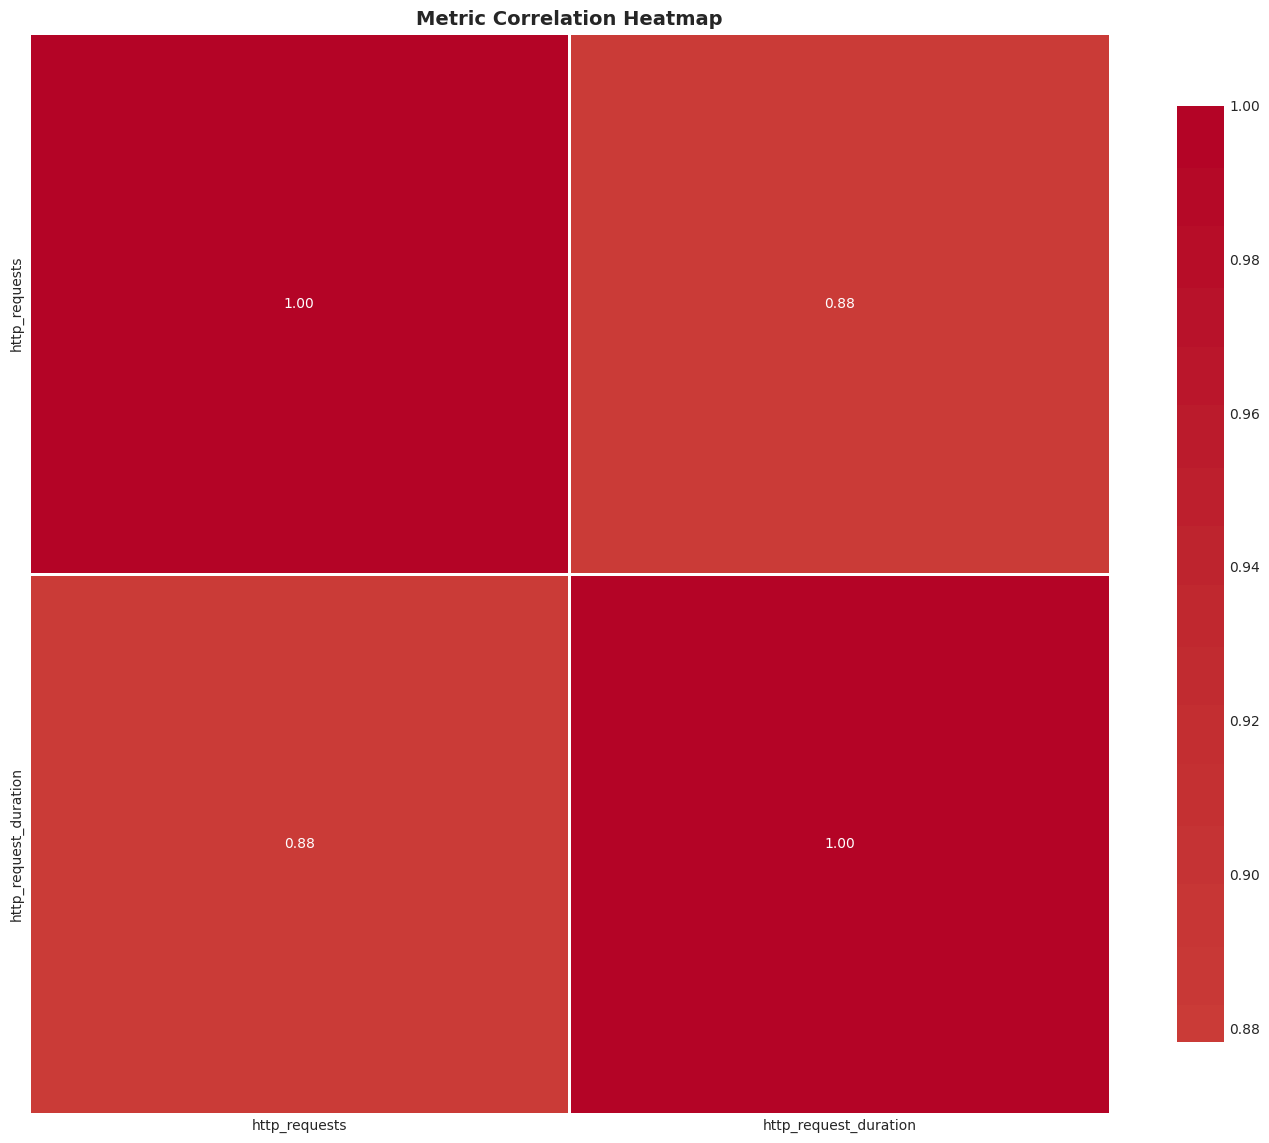


🔗 High Correlations (|r| > 0.7):
   http_requests                            <-> http_request_duration                   :  0.878


In [11]:
# Create a pivot table for correlation analysis
print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Prepare data for correlation
# Pivot to get each metric/container as a column
pivot_data = []

for metric in df['metric_name'].unique():
    metric_df = df[df['metric_name'] == metric]
    
    if 'label_name' in metric_df.columns:
        # Group by timestamp and container
        for container in metric_df['label_name'].unique():
            container_df = metric_df[metric_df['label_name'] == container]
            ts = container_df.groupby('timestamp')['value'].mean()
            pivot_data.append({
                'series': ts,
                'name': f'{metric}_{container}'
            })
    else:
        # Just aggregate by timestamp
        ts = metric_df.groupby('timestamp')['value'].sum()
        pivot_data.append({
            'series': ts,
            'name': metric
        })

if pivot_data:
    # Combine into DataFrame
    corr_df = pd.DataFrame({item['name']: item['series'] for item in pivot_data})
    
    # Calculate correlation matrix
    corr_matrix = corr_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Metric Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print high correlations
    print("\n🔗 High Correlations (|r| > 0.7):")
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                print(f"   {corr_matrix.columns[i]:40s} <-> {corr_matrix.columns[j]:40s}: {corr_val:6.3f}")
else:
    print("⚠️  Insufficient data for correlation analysis")

## 8. Summary and Next Steps

### Key Findings:
- Document any interesting patterns observed
- Note any anomalies or unexpected behavior
- Identify metrics that are most variable

### Next Steps:
1. ✅ Collect additional data with periodic pattern
2. Create sliding window features (15-60 min windows) -> src/preprocessing/sliding_windows.py
3. Build initial LSTM prototype for CPU prediction -> src/models/lstm_baseline.py
4. Evaluate baseline model performance

In [12]:
# Summary statistics
print("=" * 80)
print("SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 Dataset Overview:")
print(f"   Total records: {len(df):,}")
print(f"   Time range: {df['timestamp'].max() - df['timestamp'].min()}")
print(f"   Unique metrics: {df['metric_name'].nunique()}")
print(f"   Sampling interval: ~15 seconds")

print(f"\n📈 Metrics Summary:")
for metric in df['metric_name'].unique():
    metric_df = df[df['metric_name'] == metric]
    print(f"\n   {metric.upper()}:")
    print(f"      Records: {len(metric_df):,}")
    print(f"      Mean: {metric_df['value'].mean():.4f}")
    print(f"      Std: {metric_df['value'].std():.4f}")
    print(f"      Min: {metric_df['value'].min():.4f}")
    print(f"      Max: {metric_df['value'].max():.4f}")

print(f"\n✅ Analysis complete!")
print(f"   Ready for feature engineering and model training")

SUMMARY REPORT

📊 Dataset Overview:
   Total records: 5,929
   Time range: 0 days 00:30:00
   Unique metrics: 2
   Sampling interval: ~15 seconds

📈 Metrics Summary:

   HTTP_REQUESTS:
      Records: 484
      Mean: 2.2412
      Std: 1.5175
      Min: 0.1725
      Max: 5.0633

   HTTP_REQUEST_DURATION:
      Records: 5,445
      Mean: 2.3197
      Std: 1.7588
      Min: 0.0000
      Max: 5.0633

✅ Analysis complete!
   Ready for feature engineering and model training
